First, let's import required packages. 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import PorterStemmer

In [4]:
trainData = pd.read_csv('../data/raw/train.csv')

Next, we check distribution of different labels in our training set.

In [5]:
def generatePieChart(data, colName):
    percentage = data[colName].value_counts(normalize=True)
    values = [colName+' '+str(i) for i in percentage.index]
    plt.pie(percentage, labels=values, autopct='%1.1f%%', shadow=True)
    plt.show()
    return

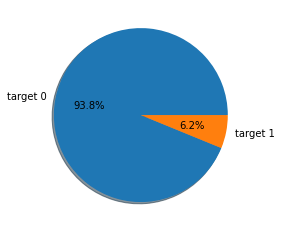

In [6]:
generatePieChart(trainData, 'target')

In [7]:
def generateBarPlot(data, colName):
    count = data[colName].value_counts()
    values = [str(i) for i in count.index]
    plt.bar(values, count)
    plt.ticklabel_format(style='plain', axis='y')
    plt.ylabel(colName+' count')
    plt.xlabel(colName);
    plt.grid(axis='y', linestyle='--')
    plt.show()
    return

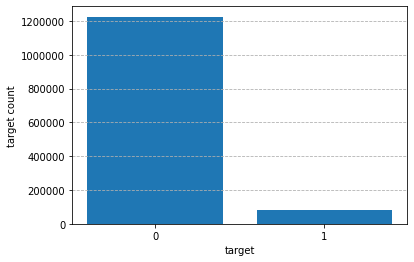

In [8]:
generateBarPlot(trainData, 'target')

As it can be seen from above, we have a large imbalance between the two categories as around 94% of training data has label 0 and only around 6% has label 1. Next, we check to see if there is any noticable different between the two groups in terms of number of words, number of letters and use of capital letters and punctuations.

In [9]:
def numWords(qtext):
    result = len(re.findall(r'\w+', qtext)) 
    return result

In [10]:
def numLetters(qtext):
    result = len([c for c in qtext.strip(string.punctuation) if c.isalpha()])
    return result

In [11]:
def numPunctuations(qtext):
    result = len([c for c in qtext if c in string.punctuation])
    return result

In [12]:
def numUppercaseLetters(qtext):
    result = len([c for c in qtext if c.isupper()])
    return result

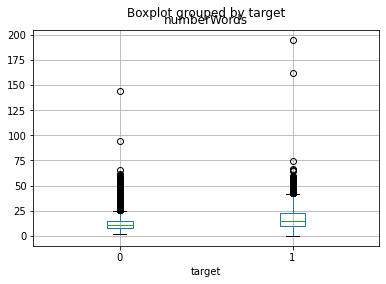

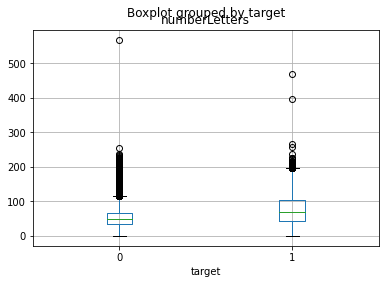

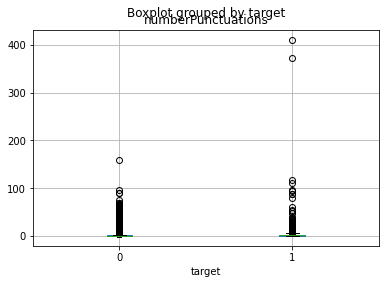

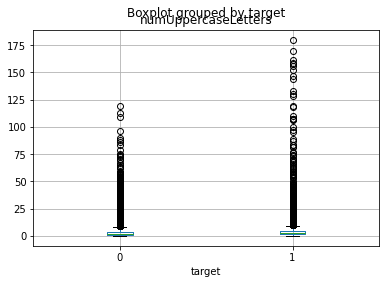

In [13]:
numWordsQuestion = trainData['question_text'].apply(numWords)
numLettersQuestion = trainData['question_text'].apply(numLetters)
numPunctuationsQuestion = trainData['question_text'].apply(numPunctuations)
numUppercaseLettersQuestion = trainData['question_text'].apply(numUppercaseLetters)
df = pd.DataFrame({'numberWords':numWordsQuestion, 
                   'numberLetters':numLettersQuestion,
                   'numberPunctuations':numPunctuationsQuestion,
                   'numUppercaseLetters':numUppercaseLettersQuestion,
                   'target':trainData['target']})
df.boxplot(column='numberWords', by='target')
df.boxplot(column='numberLetters', by='target')
df.boxplot(column='numberPunctuations', by='target')
df.boxplot(column='numUppercaseLetters', by='target')

From figure above, insincere questions seem to have more words and characters when compared to sincere questions. Next we work on preprocessing questions text by removing extra characters and stopwords and changing all letters to lower case. 

In [14]:
def removeExtraChars(qtext):
    result = [re.sub(r'[^A-Za-z ]+', ' ', sentence) for sentence in qtext]
    return result

In [15]:
def removeStopWords(qtext):
    # Remove stop words
    result = []
    for sentence in qtext:
        words = sentence.split()
        result.append(' '.join([w for w in words if w not in STOPWORDS]))
    return result

In [16]:
def preprocessText(qtext):
    
    # Remove extra characters
    qtext1 = removeExtraChars(qtext)
    
    # Lower case
    qtext2 = [sentence.lower() for sentence in qtext1]
    
    # Remove stop words
    result = removeStopWords(qtext2)
    
    return result

In [17]:
# Preprocess sincere questions
catZeroQuestions = preprocessText(trainData[trainData['target']==0]['question_text'].to_list())
# Preprocess insincere questions
catOneQuestions = preprocessText(trainData[trainData['target']==1]['question_text'].to_list())

After preprocessing question text for both sincere and insincere question, we tokenize and stem sentences and calculate document-term matrix (DTM).

In [18]:
def tokenize(sentence):
    tokens = [word for word in nltk.word_tokenize(sentence) if len(word)>1]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(item) for item in tokens]
    return stems

In [19]:
def createDTM(qtext):
    vectorizer = TfidfVectorizer(tokenizer = tokenize)
    dtm = vectorizer.fit_transform(qtext)
    result = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names())
    return result

In [18]:
dtmZero = createDTM(catZeroQuestions) 
dtmZero.shape

(1225312, 132995)

In [20]:
dtmOne = createDTM(catOneQuestions) 
dtmOne.shape

(80810, 24496)

Finally, we find word cloud for each category. 

In [21]:
def generateWordCloud(dtm):
    words = dtm.columns
    freq = dtm.sum(axis=0)
    wordFreq = dict(zip(words, freq))
    wrdCld = WordCloud(mode='RGBA',background_color='white', 
                       max_words=100).generate_from_frequencies(wordFreq)
    plt.imshow(wrdCld)
    plt.axis('off')
    plt.show()
    return

In [22]:
#generateWordCloud(dtmZero)

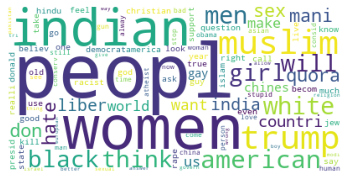

In [23]:
generateWordCloud(dtmOne)